In [1]:
import pandas as pd
import numpy as np
import os
import argparse

from sklearn.model_selection import StratifiedKFold
from sklearn.random_projection import GaussianRandomProjection

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
# from keras.layers.noise import AlphaDropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
def get_network(input_shape,units1=128,units2=64,units3=8,
                       dropout_rate1=0.2,dropout_rate2=0.1,dropout_rate3=0.1, lr=0.00004):
    model = Sequential()
    model.add(Dense(units1, activation='relu', input_shape=(input_shape,)))
    # Add one hidden layer
    model.add(Dropout(dropout_rate1))
    model.add(Dense(units2, activation='relu'))
    model.add(Dropout(dropout_rate2))
    model.add(Dense(units3, activation='relu'))
    model.add(Dropout(dropout_rate3))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=lr, epsilon=.001)  # lr=0.00004
#     opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model


def get_network_2_bn(input_shape, units, dropout, epsilon, lr=0.00004):
    units1, units2 = units
    dropout_rate1, dropout_rate2 = dropout 
    
    model = Sequential()
    
    model.add(Dense(units1, input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate1))
    
    model.add(Dense(units2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate2))
    
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=lr, epsilon=epsilon)  # lr=0.00004
#     opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model


def get_network_3_bn(input_shape, units=(256,32,8), dropout=(.2,.2,.1), epsilon=.01, lr=0.00004):
    units1, units2, units3 = units
    dropout_rate1, dropout_rate2, dropout_rate3 = dropout 
    
    model = Sequential()

    model.add(Dense(units1, input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate1))
    
    model.add(Dense(units2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate2))
    
    model.add(Dense(units3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate3))
    
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=lr, epsilon=epsilon)  # lr=0.00004
#     opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def get_network_4_bn(input_shape, units, dropout, epsilon, lr=0.00004):
    model = Sequential()
    
    units1, units2, units3, units4 = units
    dropout_rate1, dropout_rate2, dropout_rate3, dropout_rate4 = dropout
    
    model.add(Dense(units1, input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate1))
    
    model.add(Dense(units2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate2))
    
    model.add(Dense(units3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate3))
    
    model.add(Dense(units4))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate4))
    
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=lr, epsilon=epsilon)  # lr=0.00004
#     opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model


In [4]:
data_path = '/legodata/exome/'

# TW_Liver.csv  TW_Whole_Blood.csv

df_exome_cohort = pd.read_csv(os.path.join(data_path, 'cvd_merged', 'TW_Whole_Blood.csv'))

results_path = '/legodata/zhaoj/cvd_risk_time2/src/exome/'

suffix = ''

In [18]:
len(df_exome_cohort.loc[df_exome_cohort['CLASS'] == 1])

13390

In [5]:
print(len(df_exome_cohort.columns))

6697


In [27]:
df_fram_1 = pd.read_csv(os.path.join('/legodata/zhaoj/cvd_risk_time2/genetic_data/for_framingham/processed/merged_fr_results.csv'))

In [28]:
df_fram_2 = pd.read_csv('/legodata/zhaoj/shared_with_mat/exom/merged_fr_results.csv')

df_fram = pd.concat([df_fram_1, df_fram_2])

In [29]:
df_exome_cohort = df_exome_cohort.merge(df_fram[['GRID', 'predict']], how='inner', left_on='grid', right_on='GRID')
df_exome_cohort = df_exome_cohort.drop('GRID', axis=1)

In [34]:
print(len(df_fram_1))

print(len(df_fram))
print(len(df_exome_cohort))
df_exome_cohort

51661
53729
26272


,grid,XRN1,PRR4,GSTM2,LDHC,CCDC92,EPDR1,HLA-DQA1,SPSB2,C6orf99,...,PSPN,AC016757.3,CNKSR1,CAPN2,USP25,CECR1,AES,CLASS,predict_x,predict_y
0,R263024065,-0.549730,0.902886,-0.093389,-0.033464,0.022397,-0.253522,-0.031739,0.628266,0.204816,...,0.052290,1.079425,0.099398,-0.347647,0.194542,0.393165,-0.389256,0,1.0,1.0
1,R289938179,-0.146533,1.067191,-0.121218,0.769779,-0.278386,-0.238114,-0.236102,0.151083,0.264438,...,-0.123799,0.379775,0.040923,-0.153520,0.294498,-0.056937,-0.372612,1,1.0,1.0
2,R231349956,-0.257337,0.990877,-0.161597,-0.082406,0.682468,-0.064242,-0.410131,0.516610,0.396535,...,-0.018763,0.626923,0.124065,-0.068935,0.183081,0.482673,-0.344518,0,0.0,0.0
3,R239874446,-0.611755,0.689457,-0.131910,0.457643,0.966448,0.000087,-0.000813,0.140378,0.446854,...,0.070862,0.266183,0.085055,-0.444999,0.166607,-0.029794,-0.559107,0,0.0,0.0
4,R218688872,-0.410340,0.224427,-0.080369,0.791819,0.410780,-0.244797,-0.378919,0.696643,0.479404,...,0.025869,0.275976,0.198797,-0.092023,-0.302957,0.205987,-0.162056,1,0.0,0.0
5,R227359928,-0.050466,0.454433,-0.160207,-0.070903,0.421847,-0.090234,-0.194236,0.723252,0.142793,...,-0.015802,0.921061,-0.038854,0.081897,0.097135,0.142068,-0.200549,0,1.0,1.0
6,R249499919,-0.441396,0.575463,-0.193510,0.790958,0.527613,-0.068180,-0.408953,1.178835,0.269180,...,-0.031392,0.642470,0.000000,-0.282850,-0.157364,0.133934,-0.288018,1,1.0,1.0
7,R245276041,-0.412503,1.042658,-0.011534,-0.066908,1.196579,-0.255464,-0.204192,0.677051,0.774398,...,0.054516,0.487877,-0.818352,-0.089794,0.278243,0.355005,-0.158429,1,0.0,0.0
8,R288174591,0.111349,1.080876,-0.087538,-0.403468,0.123698,-0.255744,-0.198768,0.162072,0.241519,...,0.060265,0.818455,0.223425,-0.005057,0.229725,0.470285,-0.211286,0,1.0,1.0
9,R284700940,0.633455,0.731610,-0.079447,0.629162,0.198316,-0.081614,-0.192474,0.166180,0.008233,...,0.024736,0.226692,0.124026,-0.180345,0.053027,-0.067312,-0.361654,0,1.0,1.0


In [33]:
df_fram.head()

,GRID,GENDER,Original_RACE,DOB,AGE,FIRST_CVD_DATE,BASELINE,CLASS,RACE,MISSING_SYSTOLIC,RECENT_SYSTOLIC,RECENT_DIASTOLIC,RECENT_VALUE_Chol,RECENT_VALUE_HDL-C,HTN_DRUG_CNT,T2DM_CNT,Smoking,frs,risk,predict
0,R263489683,M,W,1953-08-21,65,0,2018-07-01 00:00:00.000000,0,W,0,146.0,84.0,169.0,43.0,1,1,0,62.622041,0.248112,1.0
1,R226760226,M,W,1947-11-07,71,0,2018-07-01 00:00:00.000000,0,W,0,100.0,60.0,204.0,59.0,1,0,1,62.397175,0.203670,1.0
2,R274657546,F,B,1960-09-10,46,2007-05-15,2006-11-15 00:00:00.000000,1,B,1,127.0,79.0,184.0,53.0,0,0,0,85.202967,0.022002,0.0
3,R298774406,F,A,1998-02-19,20,0,2018-07-01 00:00:00.000000,0,W,0,115.0,65.0,173.5,55.5,1,0,0,-30.790278,0.003940,0.0
4,R240463206,M,W,1942-04-26,76,0,2018-07-01 00:00:00.000000,0,W,0,130.0,84.0,265.0,47.0,1,0,0,62.701876,0.265722,1.0


In [8]:
df_fram_exome = df_exome_cohort.loc[((df_exome_cohort['predict']==0) & (df_exome_cohort['CLASS']==1)) | (df_exome_cohort['CLASS']==0)]
print(len(df_fram_exome))

19228


In [9]:
print(len(df_exome_cohort.loc[df_exome_cohort['CLASS'] == 1]))

12533


In [10]:
for col in list(df_fram_exome): 
        print('{}:\t\t{}\t\t{}'.format(col, df_fram_exome[col].min(), df_fram_exome[col].max()))
    

grid:		R200009152		R299998568
XRN1:		-1.3440385397639998		0.94435175107
PRR4:		-1.41456962673667		3.15960678504612
GSTM2:		-0.864534895758		0.279503304
LDHC:		-1.011901626907		1.7402748726099997
CCDC92:		-1.1085962269943		1.9672258056035
EPDR1:		-0.854701390025		0.03473465
HLA-DQA1:		-0.4164871802		0.0
SPSB2:		-0.137356603664		1.23472791758
C6orf99:		-0.12959156		0.8677353620799999
KANSL2:		-0.0672440762		1.867586990968
ZFYVE28:		-0.412166723		1.471107376
PAIP1:		-1.23354056529		2.1221081326061
TEKT3:		-1.7943377013457		1.6372741245700002
IFRD1:		-1.546087805778		1.586275540654
ADAM17:		-1.043418498409		0.0
EDEM3:		-2.1454728211581		0.564352393838
IQGAP1:		-0.7509595878890001		1.870302804466
COX7A1:		-0.2127878240731		1.1861177257873
SHMT1:		-0.2572364323		1.4498583547639998
SLC2A3:		-1.871678860301		0.329492583038
YPEL1:		-0.4348803982776		0.6163920640975
LAMC1:		-0.82478478413216		0.21810385878
TDRD7:		-1.10886565084		1.068841315549
NUFIP2:		-1.4169148076871		1.1854385814642
H2AFJ:		

KIAA1279:		-3.61212344828554		2.3566959880347698
PBX2:		0.0		0.7055905579999999
GOSR1:		0.0		0.030116786
NCAPG2:		-1.4576089079588002		0.9042528270239
FAM184A:		0.0		1.3147361196
ZDHHC11:		-0.3851448172		0.0
UBE2E2:		-0.07396724		0.0
GEMIN4:		-1.898528827462		0.986507962136
BCAS3:		-3.047120267067		0.822498374629
DEFA1B:		-0.553661944496		1.142132785247
DDX23:		-1.337551860417		0.8140746426459999
STK39:		-0.411024489035		4.248192569025
WDR18:		-1.08435160844033		1.4047489204840002
EFCAB2:		-0.8236595648		0.090488342339
AC131097.4:		-0.48997118		0.28397232
H3F3A:		-1.02513197237		2.24307947898
OXER1:		-2.1554273603884		0.9074413214172
ACTR8:		-3.0100072477171005		0.657365512172
CBLN1:		-1.40605353		0.9018322052825
WDR88:		-0.34035815020000004		1.2700044734
C6orf1:		0.0		0.073549524
TRIM37:		-0.536317128		0.7994999309999999
CMTM5:		-2.5378746580564		1.8712684452915
JAG2:		-4.40090714338133		-0.30963367352
TMEM176B:		-3.228713874388		2.199244149628
RBBP6:		-0.7433875740000001		0.069025826

CLDN12:		-0.1258023124		0.0
CCHCR1:		-0.191450814		0.94634674
MAX:		-1.20228922315		2.94770215941397
DGKA:		-1.205495844214		0.0
YEATS4:		-0.459088668		0.40659163
LPHN2:		-0.7880035273999999		0.1793664472
TCL1A:		-0.03507694		0.0
AKAP3:		-0.3132258734		1.0052943894
MFF:		-1.0807939174482		0.7060734517548001
VKORC1:		-1.988967173427		0.433693816722
NHLRC2:		-2.5672235312247		0.9565579213826
ZFPM1:		-1.817422259973		0.8467444056010001
LARP4B:		-1.839918517996		0.6896412508759999
ADORA2B:		-1.3230711120945		0.5803940679341999
KLF13:		-1.2521262020851		0.7896232470796999
PMFBP1:		-0.127749812406		2.58691817762
RNFT1:		-1.272876023919		1.078669767013
FBXO5:		-1.583775406512		0.994567988303
MAFB:		-1.5192328290708998		2.662575598482
INO80C:		-0.170610772		0.047207212
TRMT61B:		-1.5057332124052		1.5603243542418
SELE:		0.0		1.22221136
NECAP2:		-0.5816724755666		1.2177582456552
SLC17A4:		-0.43639494		0.10346354
PDE4DIP:		-0.03501922		0.0800636127
SREBF1:		-1.1702775399724		0.55938151518
TMEM52:

MDH1B:		-0.91618473035		2.653486985933
STK10:		-3.2765550963564		1.4383346092183995
HAP1:		-1.864741328013		0.5672939284399999
NOTUM:		-1.067965927214		0.933664556788
TTBK1:		-1.282749213405		1.785709984117
CD2BP2:		-1.314415512181		0.489794785573
C2orf54:		-0.5232879386943		2.7390512345292004
C7orf49:		-0.8470383340329001		1.2701899234045
SIGLEC12:		-0.7011830301426999		0.4061246022195
BSN:		-1.950177638511		2.802123832841
LRRC28:		-0.072080113236		0.6262999512340001
SPATA7:		-0.292521396		0.137761284
NT5DC3:		-0.226015185322		1.584853094754
SPTBN5:		-1.505213798022		0.192792128
UROS:		-0.936851768		0.300567892
QPRT:		-0.18538458		0.1778034
XKR9:		-0.0452411376536		1.234916579
DHRS1:		-0.949106657527		0.984665096892
PSD4:		-0.697306104703		2.183104794488
TTLL13:		-0.8701127358241		2.8807997406613
RP11-268J15.5:		-1.2019038713806		1.4091115001769998
SCNN1B:		-1.98901268885335		0.8240097997666441
KDELR3:		0.0		0.17449596
HLTF:		-0.4145192441		2.1031673754061
APOA1BP:		-0.5547879		0.1628

ZNF514:		-1.23747122927		1.252929988292
ZNF391:		-0.8040467994		0.9885656303
SRR:		-1.0585734649556		1.1527886752526002
MYO1F:		-0.341508497		0.678899273875
C1orf228:		-1.4309736569693		0.6675821666570999
ING5:		-1.82206061055127		3.3592495695882003
FADS2:		0.0		0.123769
SLC2A8:		-1.434567877762		1.7509608257620002
FNTB:		-0.61973248		0.02993506
ACOT6:		0.0		0.06425840000000001
ZNF518B:		-0.940649495453		0.93618355319
AURKB:		-1.1749674596196		1.0901338128126
DISP2:		-1.204385698614		4.47377166225
COBL:		-0.625094108		0.78316645565
PRMT7:		-0.9591306		1.387565468
ANKRD28:		0.0		0.14450800800000002
CNGA1:		-1.961656585415		0.133790479321
RPS17:		-1.6121884650428		4.128918188
VANGL1:		-1.885894758968		0.824804546
TTLL1:		0		0
ZNF513:		-1.482581189358		0.06932181
VEGFA:		-1.741345586004		1.6176459919330002
ZDHHC23:		-1.5791508102972		1.1269296067582
PPP1R15A:		-0.397603026858		1.260418899539
ARHGEF26:		-0.24636156		0.77293938
EIF4EBP1:		0.0		0.07666868
ABCB1:		-1.4378665724992998		2.14358

TULP2:		0.0		1.829129012
STX19:		-2.5925155183		0.7850686454389
LETM1:		-1.22336300463		1.068107937844
MTUS2:		-1.26432568		0.17974139600000005
ILK:		-0.06629284		0.08993724
BSG:		-1.149321460344		0.07177331247
BMPR2:		-0.207203166		0.636813366
MAP1LC3C:		-0.53882764465		1.805012560161
ARL6IP5:		-1.085509411529		0.0
NLRX1:		-3.2857240466790003		1.31337620065
LYZL1:		-1.96844175256715		2.56364112207844
SPIRE1:		-0.358122908		1.938014462
APOL5:		0.0		1.2707957644
THUMPD3:		-1.700523038206		0.276839763437
F2RL2:		-0.670946482495		0.004845842
EGFLAM:		-0.9131466647047		1.2406508732
KNOP1:		-0.644566853194		2.428336274119
CD276:		-0.40811263		0.909876254
PRPF3:		-1.0813784195231		1.16645256466
C21orf119:		-1.16863205647609		0.924012110393814
WDR41:		-0.5491528896846		6.0801042973774
SUOX:		-0.545132968		0.579214036874
ZMYND8:		0.0		0.06671676
UBE2K:		0.0		0.761479068
PIK3R5:		-0.543239252258		1.072784313983
NSL1:		-1.046490882659		1.009241749404
MAN2B2:		-1.019935262917		0.379259030228
VAPB

FAM183B:		-1.297588040249		2.710883074816
PIKFYVE:		-0.28653786692		1.3079526658
CDK17:		-1.3461735346572		0.6990600982551
STX17:		-0.149982648		0.530789116
PLEKHH1:		-0.19084318908		0.8990628
LRR1:		-1.8478405640726		1.1940101419823
AOC1:		-0.4847133593702001		2.2201083662709
C11orf86:		-1.3253073999999998		0.0
LY86:		-0.9676685759355		1.5755176412679
VIM:		-1.8974558584		1.5823770931905
KIF5A:		-1.2731037797781002		1.5624291079
SLC22A7:		0.0		0.13193216
GSTM1:		-0.748670332		0.185232695321
SMG1:		-0.5898379059800001		1.06148626966
GABARAPL2:		-0.2805848		0.4806708
SHARPIN:		-1.528461807742		0.096375908308
DIP2A:		-0.957830178915		0.909033009254
COL3A1:		-1.849778026959		2.000627805431
PPIG:		-0.895224877574		0.7431943602358
PRCP:		-0.9117351760189		1.6748089593172
CDS2:		-0.389856607234		0.45340424098
GOLGA4:		-1.098642427272		0.474156425943
MRPL14:		-0.278942682		0.387056354
FAM21A:		-1.02803700088		0.586940600553
C11orf73:		-0.641135054086		1.590448623
HMMR:		-0.03945558		0.0
ANGPT

NOTCH2:		-0.77726691384264		0.0
RWDD3:		-0.3983155		0.0
CINP:		-3.2682613304862005		0.1426187921365
BZRAP1:		-0.194806334		0.697518443129
SEMA7A:		0		0
NDUFA10:		-1.259795644166		1.246698962216
PKD2:		-1.8199897668567		2.4985758651493
CHI3L1:		-0.204972949		1.214194827724
ETHE1:		-1.2156554452		0.5516716332
RNF213:		-2.37778327955714		1.854254948946
PIAS4:		-0.105081085264		1.372116592428
TRABD2A:		-0.44585888		0.514864384
IL17RE:		-0.13481822		0.0
LSG1:		-0.2079611756		2.2489133698
METTL1:		-0.55295212030211		1.41087409881
MORN2:		-0.5502727303		2.367927034286
CCDC82:		-0.30779856402890005		1.0157562214
PIGO:		-1.052147931208		0.629608500436
HS3ST3B1:		-2.5179105883866		1.0548613444672
TYMS:		-0.052248505999999986		0.265821254
TSNARE1:		-0.233594912		0.709456456
SLC25A21:		-0.7996767456558002		1.4622058921348
ARL16:		-2.3714496646		0.251346243618
RPF2:		-0.6871420252		0.284813514
CDH23:		-0.9943616276625		1.2710757321041002
TMEM105:		-0.144535821		0.830446714
NR2C2AP:		-1.258749134885

SBNO2:		0.0		0.04396368
SIRT5:		0.0		0.280239745122
RPAP1:		0.0		0.0319205
PLAC9:		-1.6653238125999998		0.7238174101164999
ATP13A2:		-1.0694694053526		0.6619024631199
FKBP1B:		-1.242194595402		0.988506981244
HNRNPC:		-0.07358328		0.0
ELTD1:		-0.614205179522		3.082091021577
BEND4:		-2.2779973779526		1.3334950636015
KCNH2:		-0.858386424992		0.098983038
F10:		-0.8971641352840001		1.374618137557
CENPV:		-0.928353227907		0.0
RCBTB2:		-0.3510029216		0.9288519442769
IREB2:		-1.259370457387		0.6698196813710999
HSD17B12:		-1.504829680558		0.990900743817
ABHD15:		-2.169501455016		1.102763979573
NEDD1:		-0.1345721		0.0
ITGB8:		-0.9931960702257		3.2498850186930603
ANKRD24:		-2.956706931846		2.13993906596632
NME7:		-1.20068406081578		1.0510208035490798
PRKD3:		-0.48826239193		1.3238636483569
NAPSA:		-1.80678761201456		1.4021905161480002
LRRD1:		-0.94213624299		0.15235402
WFIKKN1:		-0.2092071642269		1.0154821532
LILRA3:		-1.1010572172082		0.0009881276
AC138969.4:		-0.6095773898499		0.9017380022
C5:	

In [11]:
from sklearn.preprocessing import StandardScaler 

def std_scale_train_test(X_train, X_test):
    print('BEGIN STD SCALE')

#     X_train = df_train.drop(['CLASS', 'GRID'], axis=1)
#     X_test = df_test.drop(['CLASS', 'GRID'], axis=1)

    std_scaler = StandardScaler()
    std_scaler.fit(X_train)

    X_train_std = std_scaler.transform(X_train)
    X_test_std = std_scaler.transform(X_test)

    X_train_std = pd.DataFrame(X_train_std)
    X_train_std.columns = list(X_train.columns)

    X_test_std = pd.DataFrame(X_test_std)
    X_test_std.columns = list(X_test.columns)
    
    for col in list(X_test_std): 
        print('{}:\t\t{}\t\t{}'.format(col, X_test_std[col].min(), X_test_std[col].max()))

#     X_test_std['CLASS'] = list(df_test['CLASS'])
#     X_test_std['GRID'] = list(df_test['GRID'])

#     X_train_std['CLASS'] = list(df_train['CLASS'])
#     X_train_std['GRID'] = list(df_train['GRID'])

    return X_train_std, X_test_std

In [12]:
from keras.layers import Input
from keras.models import Model

def encode(X_train, X_test, n_comp):
    
    input_layer = Input(shape=(X_train.shape[1],))
    encoded = Dense(n_comp, activation='relu')(input_layer)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(encoded) 
    autoencoder = Model(input_layer, decoded) 
    
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    autoencoder.fit(X_train.values, X_train.values, 
                       epochs=20, 
                       batch_size=128, 
                       shuffle=False, validation_data=(X_train.values, X_train.values))
    
    encoder = Model(input_layer, encoded)
    
    X_train_encoded = encoder.predict(X_train.values) 
    X_test_encoded = encoder.predict(X_test.values) 
    
    return X_train_encoded, X_test_encoded 

In [14]:
from sklearn.utils.class_weight import compute_class_weight 

def run_exome(df_train, df_test): 
    X_train, y_train = df_train.drop(['CLASS', 'grid', 'predict'], axis=1), df_train['CLASS']
    X_test, y_test = df_test.drop(['CLASS', 'grid', 'predict'], axis=1), df_test['CLASS']
    
    X_train, X_test = std_scale_train_test(X_train, X_test) 

#     rand_proj = GaussianRandomProjection(n_components=200)
#     rand_proj.fit(X_train)
#     X_train = rand_proj.transform(X_train)

    if False: 
        X_train, X_test = encode(X_train, X_test, n_comp=100)


    print(X_train.shape) 
    
#     model = get_network_2_bn(input_shape=X_train.shape[1], units=(256,8), dropout=(.2,.1), epsilon=.01)
#     model = get_network_3_bn(input_shape=X_train.shape[1], units=(1024,256,8), dropout=(.2,.2,.1), epsilon=.1)
    
    model = get_network_2_bn(input_shape=X_train.shape[1], units=(256, 8), dropout=(.75, .5), epsilon=.001)
    
#     print('# of subjects in cohort:\t{}'.format(X))
#     print('# of features in cohort:\t{}'.format(len(df_fram_genetic.columns)))
    
    hdf5_file_path = os.path.join(results_path, 'model', 'test_exome.hdf5')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
    checkpointer = ModelCheckpoint(filepath=hdf5_file_path, verbose=1,
                                   save_best_only=True)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    num_epochs = 150

    class_weight_vec = compute_class_weight(class_weight='balanced',
                                            classes=[0,1],
                                            y=y_train)
    
    history_model = model.fit(X_train,
                              y_train,
                              batch_size=256,
                              class_weight={0: class_weight_vec[0], 1: class_weight_vec[1]},
                              epochs=num_epochs,
                              verbose=1,
                              validation_split=0.11, callbacks=[reduce_lr, checkpointer])

    model.load_weights(hdf5_file_path)

#     X_test = rand_proj.transform(X_test)
    y_score = model.predict(X_test)

    auc = roc_auc_score(y_test, y_score)  # main_input
    # cvs_aucs.append(auc)
    ap = average_precision_score(y_test, y_score)


    dict_train_history = {'epoch': list(range(num_epochs)),
                          'val_loss': history_model.history['val_loss'],
                          'loss': history_model.history['loss'],
                          'val_acc': history_model.history['val_acc'],
                          'acc': history_model.history['acc'],
                          'fold': [fold] * num_epochs}
    
    return {'CLASS': list(y_test), 'SCORE': list(y_score)}, dict_train_history

skf = StratifiedKFold(n_splits=10, 
                     random_state=1)
# skf.get_n_splits(X=df_fram_exome,
#                  y=df_fram_exome['CLASS'])
#
# feat_lst = list(df_fram_genetic.columns)
# feat_lst.remove('CLASS')
# feat_lst.remove('GRID')
#
# df_pred_cv = pd.DataFrame()
# df_feat_cv = pd.DataFrame({'FEATURE': feat_lst})

df_pred_cv = pd.DataFrame()
df_train_cv = pd.DataFrame()

fold = 0


for train_index, test_index in skf.split(X=df_fram_exome,
                                         y=df_fram_exome['CLASS']):
    
    print('FOLD: {}'.format(fold))

    df_train, df_test = df_fram_exome.iloc[train_index], df_fram_exome.iloc[test_index]

    dict_fold_pred, dict_fold_train = run_exome(df_train, df_test) 
        
    df_pred_cv = pd.concat([df_pred_cv, pd.DataFrame(dict_fold_pred)]) 
#     df_cv = pd.concat([df_cv, pd.DataFrame({'FOLD': [fold], 'AUC': [auc], 'AP': [ap]})])
    df_train_cv = pd.concat([df_train_cv, pd.DataFrame(dict_fold_train)])

    fold += 1

    break

# return df_cv, df_cv_train_history
# fold = 0
# for train_index, test_index in skf.split(X=df_fram_genetic,
#                                          y=df_fram_genetic['CLASS']):


FOLD: 0
BEGIN STD SCALE
XRN1:		-3.3693913370078534		3.6990447637269184
PRR4:		-3.371344332839431		3.7970813546625797
GSTM2:		-4.756191384225067		2.690499681694055
LDHC:		-1.9488129517887638		4.009437273719854
CCDC92:		-3.802431625072919		3.523854798928597
EPDR1:		-3.9108933639433525		1.4414127287996608
HLA-DQA1:		-1.5486757431755598		1.7624480563557847
SPSB2:		-1.740638972175803		2.543641431035248
C6orf99:		-1.9982754122709865		2.7769825628887306
KANSL2:		-1.56866898112706		2.8650314257615817
ZFYVE28:		-1.6215509221065587		3.275820993146017
PAIP1:		-3.2118826278426305		3.3854430627910808
TEKT3:		-3.638912433227611		3.1548999205592576
IFRD1:		-3.2791662273908484		2.667207470173395
ADAM17:		-3.0047292433984683		1.7990891545145289
EDEM3:		-4.035462321550843		2.8112332020221684
IQGAP1:		-1.6300262784669322		4.132880632978789
COX7A1:		-1.8029143121218887		3.7634870962617577
SHMT1:		-1.804326553444511		4.586976989393835
SLC2A3:		-4.724731292399838		1.78836323349325
YPEL1:		-1.787665616179100

OGFOD1:		-2.1388466288365433		2.2134866963278927
TTLL7:		-2.946912612637071		1.8182792166377646
EIF4EBP3:		-6.364596614337298		0.3473677113858827
INTS1:		-3.202010695077412		3.816191357627323
KCNMB3:		-3.750142880477843		2.821494516105102
GRAMD4:		-3.20918611353644		3.2791989613722454
ATF7:		-1.6712864693389156		2.420611775335188
MZT2A:		-3.9242810836977866		3.9742769163049037
NCS1:		-2.807939090620852		3.508614469184583
SLC35A3:		-1.2587364332139936		1.575706798720983
RRAGC:		-3.2198606449099483		3.234674175054877
C17orf97:		-0.8746000791106664		2.3542314518952314
SLC38A10:		-1.7025188974496186		4.272815680125014
SF3B5:		-3.8438283613082573		3.8043554646097144
PDCD5:		-3.9687915066928228		2.5753154858974807
GPR17:		-3.430379580094399		5.263422873902719
FPGT:		-2.503514731956419		3.788502021343689
INPP5B:		-0.8372400025684783		2.5095086974115564
RILP:		-3.6230354739903166		2.6298553326817693
CKAP2L:		-2.6462938353797454		2.8974152386568375
EXO5:		-3.4344268758509005		2.922110148707128


C3orf33:		-4.321608206897239		3.720140807199808
SOCS2:		-3.235914751620037		3.289555933743436
LYSMD4:		-1.6378078541538048		3.3674205536447785
CHMP3:		-3.00978159706361		3.0199951179466002
WDPCP:		-4.134201757155208		2.1147549137131247
C9orf139:		-3.8631157941250116		2.895033028607477
PSMF1:		-3.1700942493448645		3.459290636508037
ZNF615:		-3.750776725508001		3.1418746573980605
DHX16:		-4.276045739623544		0.7219857572242565
TRDMT1:		-4.1977209542250336		1.833837188146563
C2CD4B:		-4.358919959347279		2.8220521985656886
DERL1:		-2.9783756160059442		4.2178315935931945
ZNF90:		-5.73119115127734		0.9915893022074809
LTB4R:		-3.0241402405470432		1.0370914364575816
UBR4:		-3.1255377905909043		3.4992771432413052
SLC9A8:		-4.083012905424728		2.335776750516742
C6orf141:		-2.5990891952848045		1.776758203163285
LACTB2:		-3.172005748673661		3.0175194006179127
ZNF519:		-2.9348480748389534		3.4075750881714244
CCDC81:		-4.000009829925845		1.4727331823283605
CACNA2D4:		-3.532194265066		3.69887928780097


MRPL36:		-3.0542849026118266		3.9834909267549774
CLCN6:		-0.6172824070599865		3.2802023347775493
ZNF655:		-0.6367118556932083		2.981528092254862
KIR2DL4:		-4.461405959207089		3.2364928219050264
AQP4:		-3.996042576376965		4.281622465459424
TDGF1:		-2.450180383998951		4.153439931255463
CTD-2210P24.4:		-2.178421924007536		3.587340952698328
ANGEL2:		-3.2873634533316		2.5821684747694977
SHB:		-3.639484040572568		3.3224206669541876
CEP85L:		-3.5202532786453014		3.2183250829374064
ZNF266:		-2.223302795941507		2.3190276386137536
SPATA13:		-2.4813468905949456		1.7058007985051054
RTN4:		-2.2016865638436336		2.4407193453742986
TXNDC5:		-3.8872615321453505		0.5666590562300301
CHRNA4:		-2.022243146481018		2.4888842335290513
TBC1D31:		-3.0659498430793604		0.6751845739567283
GANAB:		-4.47084644086076		2.106515794916783
CCDC38:		-3.3241138082102597		2.850197236278967
TSPAN9:		-3.299447682240053		1.5394642856681173
TAX1BP3:		-3.282857233565941		3.3530513987452997
PVRL1:		-0.20902079285946648		4.9302500

CIB1:		-2.848693624490678		2.486183346822056
MROH6:		-1.1833408454072913		5.645795751932418
UBE2J1:		-2.8948230334934917		5.836571046650731
PON3:		-3.1900643674875275		3.6585755449671105
C1orf162:		-3.8949780559944225		3.2937073979327587
JUND:		-4.306765063334171		3.6188543802120314
NUP85:		-2.104683120967629		3.8482815454374157
SET:		-3.6979734615739206		3.0603904700507365
LIFR:		-4.052828792383155		2.5347463347731893
TMPRSS9:		-2.901988674324445		2.0239436812291363
ATAD3C:		-2.104539680620837		4.337319015489051
CYP2C18:		-5.167777051490449		1.4019611136485195
SLC6A19:		-3.430542654647025		0.6288077012571346
SERPINB3:		-2.653566071351017		4.325144952888638
SCRN3:		-4.059084642310486		3.0648616705657656
MEPCE:		-2.603598609172852		4.140126445897047
DHFRL1:		-2.504565219007666		3.5312292390264948
CTDSP2:		-3.408363607892563		3.4979931003899747
MALL:		-4.780680022026724		3.4064219970837595
ZNF177:		-3.8702058930163643		2.801064987822326
PEX6:		-1.8692208015781855		1.4613481350630768
RANB

MPPED1:		-5.014087717506762		1.645239696401461
NAPG:		-1.8818099352348847		1.5641989893081414
COX16:		-6.233068313968381		0.8186937320107028
CTSW:		-3.1257598606149712		1.5508345318356909
PFN2:		-7.778344235392498		0.978675429855298
ACSM5:		-5.238623120094836		1.0693656741446158
TSPAN3:		0.0		0.0
CTNS:		-3.3101561356150992		2.567060982020051
MYH11:		-4.79005654328497		2.632511745640384
SPAG5:		-0.8221769828383062		3.44246615524862
DAK:		-4.269748187981882		3.100136816950344
TMEM116:		-0.8051327677925543		4.617713618098435
TSKS:		-5.17564526701138		2.5761602719917116
TMEM98:		-3.1851982389417164		2.093817323851516
SLC2A9:		-0.9287390882866238		2.233353782897076
EGR1:		-3.8298465309922607		4.319118777585184
MRE11A:		-2.680199856367015		3.4373880734309856
COL8A2:		-2.828529348047635		3.9415880599653477
DHX38:		-3.2967966654196266		3.9786604622169928
IL1R2:		-2.5001472889679084		4.7236148827743065
RP11-676J12.7:		-1.5603098733163294		1.938819363148992
TCF3:		-0.3728217671951337		5.79965318

CSGALNACT2:		-1.1086881789070637		4.428798104905289
FURIN:		-5.460612741505254		0.38412347488058135
RHBG:		-2.7676788074305483		1.6618940151483457
CAT:		-3.359846477702263		2.692643885408758
SERPINA5:		-2.256020558914967		4.124635463064735
RXRB:		-2.6417520817376223		2.5984155748882114
ALLC:		-1.5102975498986482		4.121666804632838
SOX7:		-2.645351970851327		4.121304465070541
TRABD:		-3.2496989825989213		3.0859884304532312
GTF2E1:		-2.4432221319385206		4.2622249559066185
RORA:		-1.1202811737089458		3.292367962098187
CCDC91:		-3.311120735952018		3.079122527690523
BCL7A:		-3.809186124939545		3.2628912102047085
HMGN1:		-3.3245461073499603		3.2329389674782605
GCK:		-2.3696213969311803		4.263584663804355
TMX1:		-4.121684845466682		1.9449563059402535
WTIP:		-3.0333970982698646		3.3885829347343366
UBE2V1:		-2.8784629080777884		3.2454810806347534
TTC9:		-2.8802245058525435		3.0344545261368765
PEX26:		-3.945557097119367		3.5219037462613554
SMUG1:		-2.0134689375259778		1.403745632337362
PILRA:		-

MSL1:		-2.33862062464026		3.7647517605655842
CISD1:		-2.139483306530405		3.919333182813763
HIBCH:		-1.9795359783008128		1.1890804576017204
CCK:		-3.980553989493823		2.8963734203313303
CYP4A22:		-3.5508060643062827		2.8728469651804716
DNAJB12:		-3.2924352002359933		2.9938978520206576
APOBR:		-2.52414447361935		0.7880178760440717
SERINC3:		-3.5901890328512596		5.625463640314809
CYP2A13:		-2.6031075207151573		3.332537275719526
S100A10:		-2.1186438422010467		2.9097790424359675
ASTN2:		0.0		0.0
CCDC40:		-0.8518010861227081		2.3905117167966776
UBTD2:		-3.2331293060897286		3.225199565751232
TAOK3:		-3.5321910671636196		4.610781672019457
GNAZ:		-3.2555861669937585		3.191578651311735
RTF1:		-4.117688620800502		3.4891027748089245
ARF5:		-3.3358942985444076		4.362975926141842
TMED6:		-2.5197060647609035		1.7531977592361292
SLITRK3:		-2.8352132602347857		3.752558986705986
UNC119:		-0.7354309241651672		3.702398011272869
OLFML3:		-3.0697585590422327		4.311746103788477
DDX59:		-3.028674139573212		2.7

DHRS7:		-3.8379918915075715		1.909195539589157
MRPL20:		-2.0965384343981524		4.824408790662538
FAM229B:		-3.0843159803078684		3.776058493846738
GLRX:		-2.7462507531323506		1.3876999954206188
CCNO:		-4.2052256932310925		2.1546451883584283
EIF2B1:		-2.883108303726961		2.927711687566854
GNG12:		-3.660665408208763		2.3586155404538514
ARHGEF28:		-2.6218202061467464		3.057147782073325
PTS:		-3.9464090975865513		2.4714529115681043
TBC1D16:		-3.2107972058135577		3.7626687742394447
ALDH5A1:		-1.938792000060743		1.0482984610123134
C16orf71:		-3.03205164588473		4.036336954863801
LRP1B:		-3.1598661971271373		3.7592262446946663
MYOM1:		-3.4386615147281803		4.166971775415821
PAQR6:		-1.9558128147094904		2.0534647054339232
FANCG:		-1.6335678604728936		2.3980922044774564
TPSD1:		-3.253494845615825		2.309286886866874
GNB1:		-2.4863045834305537		4.339939878254522
AGL:		-3.8608611557121537		3.9386275054047184
GNPNAT1:		-3.464855104014159		3.5177774836905167
VLDLR:		-3.130449781964859		3.20600535394742
NO

BRAT1:		-3.8757110332388662		3.773466046282418
SNX2:		-5.172829249761154		1.3001869456459199
MARCH9:		-5.250970027254933		3.1193290188516576
ST3GAL4:		-3.3150567684932435		3.959204674147985
SLC25A1:		-4.106432164140183		3.167254597746385
IKBIP:		-1.8042534824579373		3.7442504463455544
TMC5:		0.0		0.0
KIF16B:		-3.596120910096126		1.568006567258995
WDSUB1:		-3.21260547663538		3.7049160234629017
FBXO27:		-1.1644846301155993		3.0254582623009303
ABHD6:		-2.7072730715990097		2.459484785357102
DDX55:		-3.9598056415742247		1.6582201140748232
ZNF215:		-1.708127822304141		3.6124060128599553
CDC14A:		-2.255119202599287		1.1501957935880078
LYNX1:		-1.2201596447660235		1.7761136566657174
CCT6B:		-3.8957394072137914		2.604452468904089
HLA-G:		-0.6104090113940529		4.459955207788381
SNTB2:		-3.2042690880284748		0.9797083388350957
KIAA1456:		-2.725691627052547		2.980373875709757
C1QL3:		-1.8793626142248794		1.3645928984658908
MED26:		-3.540751315291971		2.485817328392246
DARS2:		-2.8279187226198896		3.

SETDB2:		-1.1717373384734548		3.362352619778679
MED20:		-3.683438318570323		2.913693480393771
TDRD15:		-4.024760938546164		5.06396102728326
SDHAF1:		-3.094145854089144		5.19732839267651
OSR1:		-1.8008580109146415		1.0852620195245972
XYLB:		-2.5920482725133738		3.0543560968588093
POPDC2:		-1.6358855100066265		1.7017613215310727
WNT9B:		-3.2460527529001824		3.958437421355331
KCNS3:		-2.0863235090144077		3.675844683278084
CENPC:		-3.7109259919901163		3.5448248982793893
METTL2B:		-2.1281585835916306		4.212049519727222
H2AFY:		-3.1807605495094355		3.0773411550463563
AMZ2:		-2.5173566932339857		2.825604418543738
CCDC149:		-3.639646456685208		3.1287344394480927
STK11:		-3.2508271281160477		2.990960594966876
YES1:		-2.9175402311713876		3.2149693633553866
BCR:		-1.8992999610671766		1.6865619990780327
CLEC18A:		-2.529079900356452		2.7075532465980308
CALY:		-1.6202174945893641		3.7738458218764785
SPTSSA:		-1.369802881783148		4.413136940283543
COL28A1:		-3.459838580935713		2.283438020386755
GPX7:	

NUCKS1:		-2.9748920120013245		3.7048194409885475
CRYBB1:		-2.0169709377414824		2.674751905902154
ALDH18A1:		-1.735107131802736		2.0183871733551
RAB6C:		-3.7182971759189964		3.0441012441215918
ATP8B2:		-3.4031945077638297		3.917315107196432
DDT:		-1.2597897819129478		1.841502180719532
SNX11:		-2.992985873762253		0.8117819231224815
AIMP1:		-3.5179013405296167		3.0685164653404797
NPIPB3:		-4.538227742748157		3.1287757831325287
C9orf40:		-0.3019690249447745		6.712768256510986
ANAPC4:		-1.4377687115016258		1.7524241788916635
CRLS1:		-3.8179829407323087		0.5725002887381095
ELMO1:		-3.651009284843711		3.457086811508685
TBC1D10B:		-3.3380246371419133		3.6821513616151718
AP1S1:		-2.6326444060815737		2.6235307491394484
PSMB9:		-2.9142955852524906		4.409149265724155
NFATC1:		-4.0944911862059445		2.4020941289782005
NPC2:		0.0		0.0
ZNF25:		-3.1078112700269753		3.13748922090765
CALU:		-1.1941974322485824		3.546651913533499
SSNA1:		-3.120384250436204		4.607088217191189
GP9:		-2.89634044318773		3.9206

Train on 15401 samples, validate on 1904 samples
Epoch 1/150
15401/15401 [==============================] - 5s - loss: 0.9005 - acc: 0.4406 - val_loss: 0.6741 - val_acc: 0.4191
Epoch 2/150
15401/15401 [==============================] - 3s - loss: 0.8911 - acc: 0.4393 - val_loss: 0.6642 - val_acc: 0.3766
Epoch 3/150
15401/15401 [==============================] - 3s - loss: 0.8842 - acc: 0.4450 - val_loss: 0.6621 - val_acc: 0.3403
Epoch 4/150
15401/15401 [==============================] - 3s - loss: 0.8856 - acc: 0.4395 - val_loss: 0.6615 - val_acc: 0.3246
Epoch 5/150
15401/15401 [==============================] - 3s - loss: 0.8730 - acc: 0.4550 - val_loss: 0.6622 - val_acc: 0.3188
Epoch 6/150
15401/15401 [==============================] - 3s - loss: 0.8663 - acc: 0.4534 - val_loss: 0.6622 - val_acc: 0.3162
Epoch 7/150
15401/15401 [==============================] - 3s - loss: 0.8544 - acc: 0.4599 - val_loss: 0.6614 - val_acc: 0.3114
Epoch 8/150
15401/15401 [==============================

15401/15401 [==============================] - 3s - loss: 0.7143 - acc: 0.5309 - val_loss: 0.6295 - val_acc: 0.3540
Epoch 50/150
15401/15401 [==============================] - 3s - loss: 0.7141 - acc: 0.5330 - val_loss: 0.6285 - val_acc: 0.3577
Epoch 51/150
15401/15401 [==============================] - 3s - loss: 0.7134 - acc: 0.5311 - val_loss: 0.6271 - val_acc: 0.3671
Epoch 52/150
15401/15401 [==============================] - 3s - loss: 0.7129 - acc: 0.5333 - val_loss: 0.6261 - val_acc: 0.3692
Epoch 53/150
15401/15401 [==============================] - 3s - loss: 0.7043 - acc: 0.5438 - val_loss: 0.6259 - val_acc: 0.3682
Epoch 54/150
15401/15401 [==============================] - 3s - loss: 0.7140 - acc: 0.5337 - val_loss: 0.6251 - val_acc: 0.3724
Epoch 55/150
15401/15401 [==============================] - 3s - loss: 0.7093 - acc: 0.5369 - val_loss: 0.6243 - val_acc: 0.3750
Epoch 56/150
15401/15401 [==============================] - 3s - loss: 0.7039 - acc: 0.5446 - val_loss: 0.6239

15401/15401 [==============================] - 3s - loss: 0.6561 - acc: 0.6002 - val_loss: 0.6070 - val_acc: 0.4879
Epoch 98/150
15401/15401 [==============================] - 3s - loss: 0.6608 - acc: 0.5909 - val_loss: 0.6067 - val_acc: 0.4932
Epoch 99/150
15401/15401 [==============================] - 3s - loss: 0.6536 - acc: 0.5987 - val_loss: 0.6067 - val_acc: 0.4932
Epoch 100/150
15401/15401 [==============================] - 3s - loss: 0.6538 - acc: 0.5974 - val_loss: 0.6066 - val_acc: 0.4937
Epoch 101/150
15401/15401 [==============================] - 3s - loss: 0.6575 - acc: 0.5986 - val_loss: 0.6065 - val_acc: 0.4968
Epoch 102/150
15401/15401 [==============================] - 3s - loss: 0.6554 - acc: 0.5935 - val_loss: 0.6067 - val_acc: 0.4953
Epoch 103/150
15401/15401 [==============================] - 3s - loss: 0.6484 - acc: 0.6031 - val_loss: 0.6063 - val_acc: 0.5000
Epoch 104/150
15401/15401 [==============================] - 3s - loss: 0.6506 - acc: 0.6076 - val_loss: 0

0.53116689601


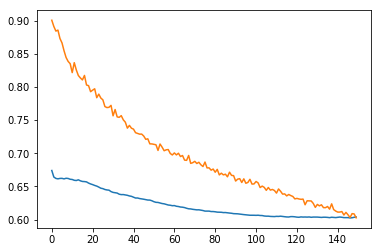

In [15]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score

y_score = list(df_pred_cv['SCORE']) 
y_test = list(df_pred_cv['CLASS'])
y_pred = [0 if score < .5 else 1 for score in y_score]

print(roc_auc_score(y_test, y_score))

plt.plot(df_train_cv['epoch'], df_train_cv['val_loss'])
plt.plot(df_train_cv['epoch'], df_train_cv['loss'])
plt.show()

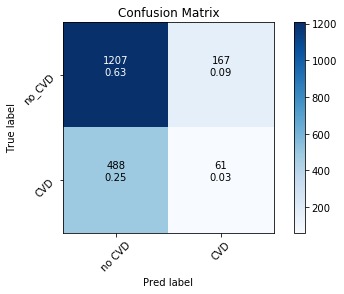

In [30]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, y_pred)
c_matrix_norm = c_matrix.astype('float') / c_matrix.sum()
c_matrix_norm

plt.imshow(c_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix') 
plt.colorbar()
tick_marks = np.arange(len(['no CVD', 'CVD']))
plt.xticks(tick_marks, ['no CVD', 'CVD'], rotation=45)
plt.yticks(tick_marks, ['no_CVD', 'CVD'], rotation=45)
                        
fmt = 'd'
thresh = c_matrix.max() / 4.
for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
#     plt.text(j, i, format(c_matrix[i, j], fmt),
    plt.text(j, i, '{}\n{}'.format(c_matrix[i,j], format(c_matrix_norm[i,j], '.2f')),
             horizontalalignment="center",
             color="white" if c_matrix[i, j] == c_matrix.max() else "black")
    
plt.tight_layout() 
plt.ylabel('True label') 
plt.xlabel('Pred label')

plt.show()